# Information Theoretic Quantum Phase Estimation for Hydrogen with the Iceberg Code

Install `pytket` if it is not available (it is used when handling the results):

In [ ]:
# !pip install pytket==1.40.0

We rely on the `algorithm` module for some utility functions:

In [1]:
import numpy as np
from algorithm import generate_ks

The phase estimation algorithm requires to generate a number `n_samples` of circuits using different powers `k` of the controlled unitary Trotterized Hamiltonian, up to the largest power `k_max`.
A list of random angles `beta` is also needed.
Overall, a given pair `(k,beta)` correspond to a single circuit.

In [2]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 50  # this will set how many circuits we need to run for the QPE
error_rate = 0.0 # for a noiseless simulation we can set this to 0


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()


## Hamiltonian for the tapered 1-qubit Hydrogen molecule

Coefficients for the controlled unitary Trotterized Hamiltonian $e^{-i \delta t H}$ are defined below

In [3]:
# 1-qubit controlled Hamiltonian trotterization coefficients
CZ = 0.7960489286466914
CX = -0.1809233927385484
CI = -0.3209561440881913
DELTAT = 0.1
# This is the reference energy from a full configuration interaction calculation
FCI_ENERGY = -1.13730605

## CUDA-Q Circuits

This is needed to debug `CUDA-Q` calls:

In [1]:
# import os

# os.environ["CUDAQ_LOG_LEVEL"] = "info"
# os.environ["CUDAQ_LOG_LEVEL"] = "trace"

In [4]:
import cudaq
cudaq.set_target("qpp-cpu")

In [5]:
@cudaq.kernel()
def qpe_iceberg(
    k: int, beta: float, syndrome_interval: int, coeffs: list[float]
):
    q = cudaq.qvector(6)
    # FT plust state preparation
    h(q[0])
    x.ctrl(q[0], q[4])
    x.ctrl(q[0], q[1])
    x.ctrl(q[0], q[4])
    h(q[0])
    h(q[1])
    h(q[2])
    bit0 = mz(q[4])
    x.ctrl(q[2], q[5])
    x.ctrl(q[2], q[3])
    x.ctrl(q[2], q[5])
    bit1 = mz(q[5])
    # HF state preparation
    x(q[0])
    x(q[2])
    # control-U^{k} and Rz(beta) operations
    for i in range(k):
        exp_pauli(coeffs[0], q, "IIZZII")  # this is the pauli exponential e^{i c Z2Z3}
        exp_pauli(coeffs[1], q, "IZZIII")  # this is the pauli exponential e^{i c Z1Z2}
        exp_pauli(coeffs[2], q, "XIXIII")  # this is the pauli exponential e^{i c X0X2}
        exp_pauli(coeffs[3], q, "YIYIII")  # this is the pauli exponential e^{i c Y0Y2}
        if i + 1 >= k:  # no syndrome measurement in the last iteration
            break
        if (i + 1) % syndrome_interval == 0:
            reset(q[4])
            reset(q[5])
            h(q[5])
            x.ctrl(q[5], q[0])
            x.ctrl(q[0], q[4])
            x.ctrl(q[1], q[4])
            x.ctrl(q[5], q[1])
            x.ctrl(q[5], q[2])
            x.ctrl(q[2], q[4])
            x.ctrl(q[3], q[4])
            x.ctrl(q[5], q[3])
            bit0s = mz(q[4])
            h(q[5])
            bit1s = mz(q[5])
    exp_pauli(coeffs[4] * k + beta, q, "IZIZII")
    # FT measurement
    reset(q[4])
    reset(q[5])
    x.ctrl(q[0], q[4])
    h(q[5])
    x.ctrl(q[5], q[4])
    x.ctrl(q[1], q[4])
    x.ctrl(q[2], q[4])
    x.ctrl(q[5], q[4])
    x.ctrl(q[3], q[4])
    bit0m = mz(q[4])
    h(q[5])
    bit1m = mz(q[5])
    # Final Measurements
    h(q)
    logical_qubits_and_flags = mz(q)

In [6]:
from math import pi

coefficients = np.array(
    [
        -pi / 2 * c
        for c in [CZ * DELTAT, -CZ * DELTAT, CX * DELTAT, CX * DELTAT, -CI * DELTAT]
    ],
    dtype=np.float64,
)

In [9]:
counts = cudaq.sample(qpe_iceberg, 2, -0.07, 1, coefficients, explicit_measurements=False, shots_count=100)
counts.dump()

{ 
  __global__ : { 000000:6 000001:8 000010:4 000011:9 001100:5 001101:2 001110:6 001111:4 010100:1 010101:3 010111:1 011000:2 011001:1 011011:2 100100:2 100110:1 101000:2 101001:1 101011:3 110000:7 110001:7 110010:5 110011:4 111100:4 111101:8 111110:1 111111:1 }
   bit0 : { 0:100 }
   bit0m : { 0:100 }
   bit0s : { 0:100 }
   bit1 : { 0:100 }
   bit1m : { 0:100 }
   bit1s : { 0:100 }
   logical_qubits_and_flags : { 000000:6 000001:8 000010:4 000011:9 001100:5 001101:2 001110:6 001111:4 010100:1 010101:3 010111:1 011000:2 011001:1 011011:2 100100:2 100110:1 101000:2 101001:1 101011:3 110000:7 110001:7 110010:5 110011:4 111100:4 111101:8 111110:1 111111:1 }
}


In [12]:
for b, c in counts.get_register_counts("logical_qubits_and_flags").items():
    print(f"bitstring = {b}, count = {c}")

bitstring = 011001, count = 1
bitstring = 000010, count = 4
bitstring = 110011, count = 4
bitstring = 010111, count = 1
bitstring = 010100, count = 1
bitstring = 010101, count = 3
bitstring = 001111, count = 4
bitstring = 111110, count = 1
bitstring = 001100, count = 5
bitstring = 011000, count = 2
bitstring = 011011, count = 2
bitstring = 001101, count = 2
bitstring = 000011, count = 9
bitstring = 000001, count = 8
bitstring = 111111, count = 1
bitstring = 110010, count = 5
bitstring = 111100, count = 4
bitstring = 111101, count = 8
bitstring = 110000, count = 7
bitstring = 101011, count = 3
bitstring = 101001, count = 1
bitstring = 100100, count = 2
bitstring = 000000, count = 6
bitstring = 001110, count = 6
bitstring = 101000, count = 2
bitstring = 110001, count = 7
bitstring = 100110, count = 1


 ## Create and sample shots from the circuits

In [14]:
# Execute the QPE circuits.
results = []
for k,b in zip(k_list,beta_list):
    rb = -pi/2*b  # rescaling needed for beta
    results.append(cudaq.sample(qpe_iceberg, k, rb, 6, coefficients, shots_count=1))

In [15]:
results[0].dump()

{ 
  __global__ : { 100110:1 }
   bit0 : { 0:1 }
   bit0m : { 0:1 }
   bit0s : { 0:1 }
   bit1 : { 0:1 }
   bit1m : { 0:1 }
   bit1s : { 0:1 }
   logical_qubits_and_flags : { 100110:1 }
}


We write a helper function to translate the CUDA-Q `SampleResult` into the pytket `BackendResult`

In [28]:
from pytket import Bit
from pytket.backends.backendresult import BackendResult
from pytket.utils.outcomearray import OutcomeArray
from typing import Counter


def get_decoded_result(result: cudaq.SampleResult) -> BackendResult:
    logical_counts = Counter()
    # check FT state preparation flags
    prep0 = result.get_sequential_data("bit0")
    prep1 = result.get_sequential_data("bit1")
    # check FT measurement flags
    meas0 = result.get_sequential_data("bit0m")
    meas1 = result.get_sequential_data("bit1m")
    # check syndrome measurements if present
    try:
        syn0 = result.get_sequential_data("bit0s")
        syn1 = result.get_sequential_data("bit1s")
    except RuntimeError:
        syn0 = ["0"] * len(prep0)
        syn1 = ["0"] * len(prep1)

    for p0, p1, m0, m1, s0, s1 in zip(
        prep0,
        prep1,
        meas0,
        meas1,
        syn0,
        syn1,
    ):
        check_prep = int(p0) or int(p1)
        check_meas = int(m0) or int(m1)
        check_syn = int(s0) or int(s1)
        if check_prep or check_syn or check_meas:
            print(
                f"Flagged Error detected! Discard [FT Prep: {check_prep} | Syn: {check_syn} | FT Meas: {check_meas}]"
            )
            continue
        else:
            # if no error detected, proceed to decode the logical readout
            logical = result.get_register_counts("logical_qubits_and_flags")
            for bitstring, counts in logical.items():
                if (
                    int(bitstring[0])
                    + int(bitstring[1])
                    + int(bitstring[2])
                    + int(bitstring[3])
                ) % 2 != 0:
                    print(
                        f"Parity Error detected! Discard [Logical Bits: {bitstring[:4]}]"
                    )
                    continue
                logical_readout = tuple(
                    [(1 - (-1) ** (int(bitstring[0]) + int(bitstring[1]))) // 2]
                )
                logical_counts[OutcomeArray.from_readouts([logical_readout])] += counts

    logical_result = BackendResult(
        counts=logical_counts,
        c_bits=[Bit(0)],
    )
    return logical_result

In [17]:
# Interpret the encoded results back in the logical space.
logical_results = [get_decoded_result(r) for r in results]


## Post-process the results using utility functions performing the Bayesian Maximum Likelihood computation

In [18]:
from algorithm import get_mu_and_sigma, bayesian_update


# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [19]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.07848 Ha
Energy sigma    =     0.04663 Ha
FCI energy      =    -1.13731 Ha


### Plot probability distribution

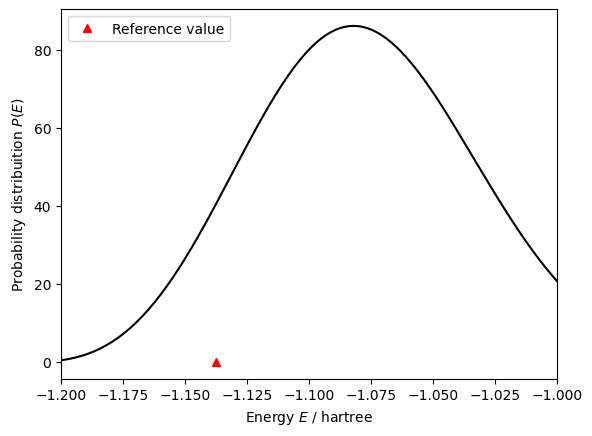

In [20]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim([-1.2,-1.0])
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()

## Noisy Simulations

We can repeat the simulation above after introducing a noise model for the gate operations. We can use some functions from [this example](https://nvidia.github.io/cuda-quantum/latest/applications/python/logical_aim_sqale.html#Running-a-CUDA-Q-noisy-simulation) in the `cuda-q` documentation

In [21]:
def get_device_noise(
    depolar_prob_1q: float,
    depolar_prob_2q: float,
    *,
    readout_error_prob: float | None = None,
    custom_gates: list[str] | None = None,
) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.NoiseModel:
    noise = cudaq.NoiseModel()
    depolar_noise = cudaq.DepolarizationChannel(depolar_prob_1q)

    noisy_ops = ["z", "s", "x", "h", "rx", "rz"]
    for op in noisy_ops:
        noise.add_all_qubit_channel(op, depolar_noise)

    if custom_gates:
        custom_depolar_channel = cudaq.DepolarizationChannel(depolar_prob_1q)
        for op in custom_gates:
            noise.add_all_qubit_channel(op, custom_depolar_channel)

    # Two qubit depolarization error
    p_0 = 1 - depolar_prob_2q
    p_1 = np.sqrt((1 - p_0**2) / 3)

    k0 = np.array(
        [[p_0, 0.0, 0.0, 0.0], [0.0, p_0, 0.0, 0.0], [0.0, 0.0, p_0, 0.0], [0.0, 0.0, 0.0, p_0]],
        dtype=np.complex128,
    )
    k1 = np.array(
        [[0.0, 0.0, p_1, 0.0], [0.0, 0.0, 0.0, p_1], [p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0]],
        dtype=np.complex128,
    )
    k2 = np.array(
        [
            [0.0, 0.0, -1j * p_1, 0.0],
            [0.0, 0.0, 0.0, -1j * p_1],
            [1j * p_1, 0.0, 0.0, 0.0],
            [0.0, 1j * p_1, 0.0, 0.0],
        ],
        dtype=np.complex128,
    )
    k3 = np.array(
        [[p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0], [0.0, 0.0, -p_1, 0.0], [0.0, 0.0, 0.0, -p_1]],
        dtype=np.complex128,
    )
    kraus_channel = cudaq.KrausChannel([k0, k1, k2, k3])

    noise.add_all_qubit_channel("cz", kraus_channel)
    noise.add_all_qubit_channel("cx", kraus_channel)

    if readout_error_prob is not None:
        # Readout error modeled with a Bit flip channel on identity before measurement
        bit_flip = cudaq.BitFlipChannel(readout_error_prob)
        noise.add_all_qubit_channel("mz", bit_flip)
    return noise

The next cell builds a custom noise model that can be used by `cuda-q`

In [22]:
# Example parameters that can model execution on hardware at the high, simulation, level:
# Take single-qubit gate depolarization rate: ~0.01% or better (fidelity ≥99.99%)
# Take two-qubit gate depolarization rate: ~0.1% (fidelity ~99.9%)
cudaq_noise_model = get_device_noise(0.0001, 0.001, readout_error_prob=0.001)

A simulator that can use the noise model is the `density-matrix-cpu` target

In [23]:
# this is needed for noisy simulations
cudaq.reset_target()
cudaq.set_target("density-matrix-cpu")

Since we have a noisy backend, we can improve our information theoretic QPE algorithm by telling our likelihood that our gates are noisy.

In [ ]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 100  # this will set how many circuits we need to run for the QPE
error_rate = 0.002 # this is for the custom noise model above: we consider a factor of 2 because we have 2 TQ gates in each controlled-U step


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()


In [25]:
# Execute the QPE circuits.
noisy_results = []
for k, b in zip(k_list, beta_list):
    rb = -pi / 2 * b  # rescaling needed for beta
    noisy_results.append(
        cudaq.sample(
            qpe_iceberg,
            k,
            rb,
            4,
            coefficients,
            shots_count=1,
            noise_model=cudaq_noise_model,
        )
    )

We now decode the measurement flags and bitstrings, discarding shots with an error:

In [29]:
# Interpret the encoded results back in the logical space.
logical_results = [get_decoded_result(r) for r in noisy_results]

Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 0 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 0 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 0 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 0]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 0 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 0]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 0]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 1 | FT Meas: 1]
Flagged Error detected! Discard [FT Prep: 0 | Syn: 0 | FT Meas

We have about 20% discard rate at this noise level and for these deep circuits

In [30]:
# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [31]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.16004 Ha
Energy sigma    =     0.03887 Ha
FCI energy      =    -1.13731 Ha


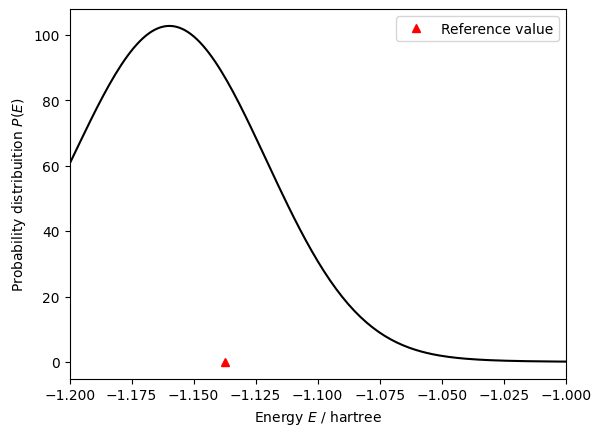

In [32]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim([-1.2,-1.0])
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()